In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from learn_d_z import learn_d_z
from tqdm import tqdm
from sklearn.linear_model import Lasso,Ridge
from update_z import update_z

# Executer le fichier build_dictionnary avant celui ci pour construire les dictionnaires si les fichiers data_atoms et data_spikes sont vide !

In [4]:
def MSE(s0,s1):
    return np.mean((s0-s1)**2)

index_1821 = 1.0*np.array([(i>=18*2)*(i<=21*2) for i in range(48)])
def MSE_1821(s0,s1):
    s0_reindex = s0.reshape(-1,48)*index_1821
    s1_reindex = s1.reshape(-1,48)*index_1821
    return MSE(s0_reindex,s1_reindex)*48/np.sum(index_1821)

index_813 = 1.0*np.array([(i>=8*2)*(i<=13*2) for i in range(48)])
def MSE_813(s0,s1):
    s0_reindex = s0.reshape(-1,48)*index_813
    s1_reindex = s1.reshape(-1,48)*index_813
    return MSE(s0_reindex,s1_reindex)*48/np.sum(index_813)

def MAE(s0,s1):
    return np.mean(np.abs(s0-s1))

index_1821 = 1.0*np.array([(i>=18*2)*(i<=21*2) for i in range(48)])
def MAE_1821(s0,s1):
    s0_reindex = s0.reshape(-1,48)*index_1821
    s1_reindex = s1.reshape(-1,48)*index_1821
    return MAE(s0_reindex,s1_reindex)*48/np.sum(index_1821)

index_813 = 1.0*np.array([(i>=8*2)*(i<=13*2) for i in range(48)])
def MAE_813(s0,s1):
    s0_reindex = s0.reshape(-1,48)*index_813
    s1_reindex = s1.reshape(-1,48)*index_813
    return MAE(s0_reindex,s1_reindex)*48/np.sum(index_813)

In [5]:
calendrier_challenge = pd.read_parquet("challenge_data/calendrier_challenge.parquet")
questionnaire = pd.read_parquet("challenge_data/questionnaire.parquet")
consos_challenge = pd.read_parquet("challenge_data/consos_challenge.parquet")
temperatures = pd.read_parquet("challenge_data/temperatures.parquet")


max_date=datetime.datetime(2011,1,1)
min_date = datetime.datetime(2009,7,15,12)
all_clients = list(set(consos_challenge["id_client"]))
day = datetime.datetime(2011,1,2)-datetime.datetime(2011,1,1)
hour = datetime.datetime(2011,1,2,12)-datetime.datetime(2011,1,2,11)
n_days = (max_date-min_date).days-365
client_challenges = np.array(questionnaire[questionnaire["participe_challenge"]==True].id_client)

def load_signal(id_client,min_time,max_time):
    consos = consos_challenge[consos_challenge["id_client"]==id_client]
    consos = consos[consos["horodate"]>=min_time]
    return consos[consos["horodate"]<max_time]["puissance_W"]

# Reconstruction d'un signal

In [6]:
def reconstruct(atom,spike):
    return np.sum([np.convolve(atom[i],spike[i][0]) for i in range(len(atom))], axis=0)

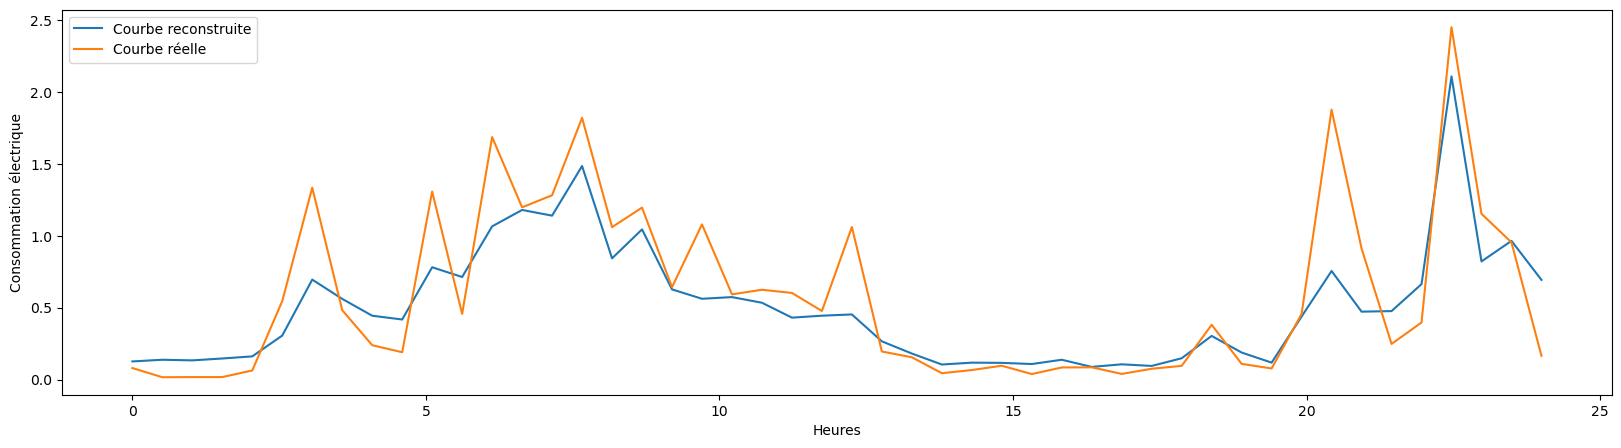

In [7]:
client = client_challenges[120]

atom = np.load('data_atoms/'+str(client)+'.npy')
spike = np.load('data_spike/'+str(client)+'.npy')
times = np.concatenate((np.linspace(12,23.5,24),np.linspace(0,11.5,24)))

test_day = 250
signal = load_signal(client, min_date+test_day*day,min_date+(test_day+1)*day)
reconstruction = reconstruct(atom,spike)[48*test_day:48*(test_day+1)]

plt.figure(figsize=(20,5))
plt.plot(np.linspace(0,24,48),reconstruction,label='Courbe reconstruite')
plt.plot(np.linspace(0,24,48),signal,label='Courbe réelle')
plt.xlabel('Heures')
plt.ylabel('Consommation électrique')
plt.legend()
plt.show()

## Performance de la reconstruction

In [8]:
n_days = (max_date-min_date).days-365+21
n_times = n_days*48
n_atoms = 15
length_atoms = 48
coef_reg = 0.5
reg = np.ones(n_times-length_atoms+1)
t_j = np.linspace(-12,12,48)
x_j = 1+t_j**2
for i in range(n_times//48-1):
    reg[48*i:48*(i+1)]=x_j
reg = reg*coef_reg
spikes_test ={}
for client in tqdm(client_challenges[:100]):
    atom = np.load('data_atoms/'+str(client)+'.npy')
    spike = np.load('data_spike/'+str(client)+'.npy')
    signaltest_client = np.array(load_signal(client,min_date+(365-21)*day,max_date-12*hour)).reshape(1,-1)

    for i in range(100):
        if i==0:
            spike_test = update_z(signaltest_client,atom,reg) 
        else:
            spike_test = update_z(signaltest_client,atom,reg,z0=spike_test)
    
    spikes_test[client] = spike_test


    
    

  1%|          | 1/100 [00:29<48:24, 29.34s/it]


KeyboardInterrupt: 

## Erreur lié à l'approximation par dictionnaire

In [ ]:
score_MSE = []
for client in spikes_test.keys():
    spike = spikes_test[client]
    atom = np.load('data_atoms/'+str(client)+'.npy')
    signaltest_client = np.array(load_signal(client,min_date+(365-21)*day,max_date-12*hour)).reshape(1,-1)
    test_reconstructed = reconstruct(atom,spike)
    score = MSE(test_reconstructed,signaltest_client)
    score_MSE.append(score)
print("MSE:",np.mean(score_MSE))

NameError: name 'spikes_test' is not defined

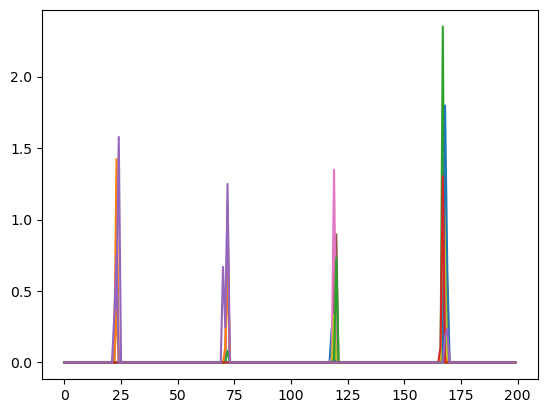

In [ ]:
for i in range(15):
    plt.plot(spikes_test[3745][i,0][0:200])

In [ ]:


def build_dataset(spike,date_min,n_days):
    X = []
    y =[]
    for n in range(21,n_days):
        date=date_min+n*day
        spike_day=spike[:,0,n*48:n*48+48].flatten()
        spike_d1=spike[:,0,(n-1)*48:(n-1)*48+48].flatten()
        spike_d2=spike[:,0,(n-2)*48:(n-2)*48+48].flatten()
        spike_s1=spike[:,0,(n-7)*48:(n-7)*48+48].flatten()
        spike_s2=spike[:,0,(n-14)*48:(n-14)*48+48].flatten()
        spike_s3=spike[:,0,(n-21)*48:(n-21)*48+48].flatten()
        # Td1 = temperatures[temperatures.horodate==date-day].temperature
        # Td2 = temperatures[temperatures.horodate==date-day*2].temperature
        # Ts1 = temperatures[temperatures.horodate==date-day*7].temperature
        # Ts2 = temperatures[temperatures.horodate==date-day*14].temperature
        # Ts3 = temperatures[temperatures.horodate==date-day*21].temperature
        # print(Td1,Ts1)
        # T = temperatures[temperatures.horodate==date].temperature
        # temp_array = np.array([T,Td1,Td2,Ts1,Ts2,Ts3]).flatten()
        spike_previous = np.concatenate((spike_d1,spike_d2,spike_s1,spike_s2,spike_s3))
        y.append(spike_day)
        x = spike_previous# np.concatenate((temp_array,spike_previous))
        X.append(x)
        if len(spike_day)!=720:
            print(len(spike_day),n,n_days,spike.shape)
    return np.array(X), np.array(y)

  0%|          | 0/307 [00:00<?, ?it/s]

7056 7056
0.3947280960573177


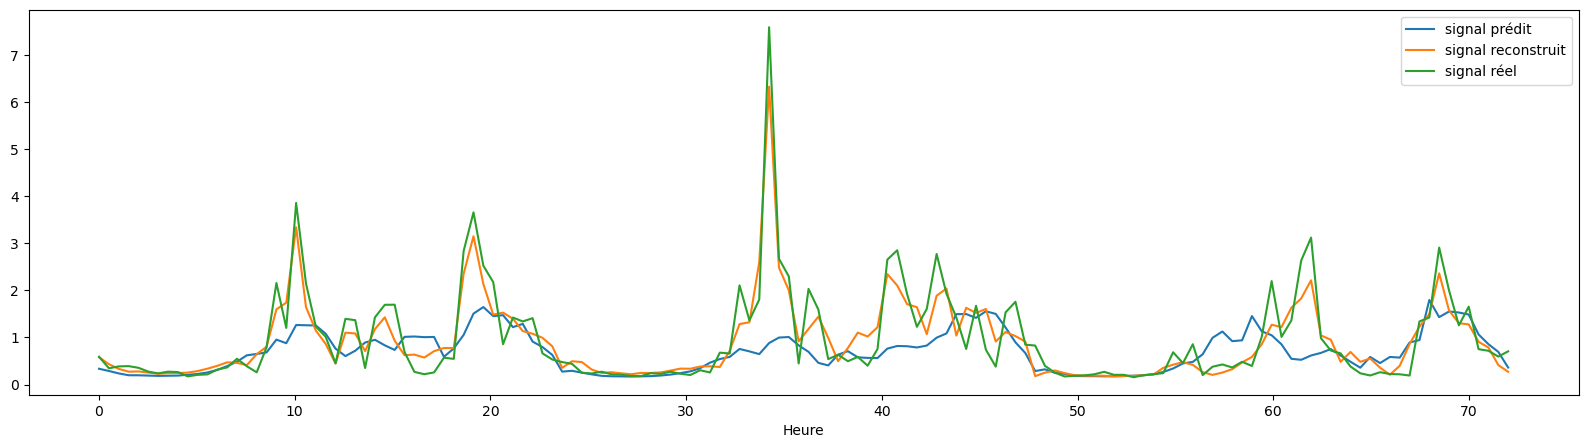

  0%|          | 1/307 [00:00<02:39,  1.92it/s]

7056 7056
0.36103824631088915


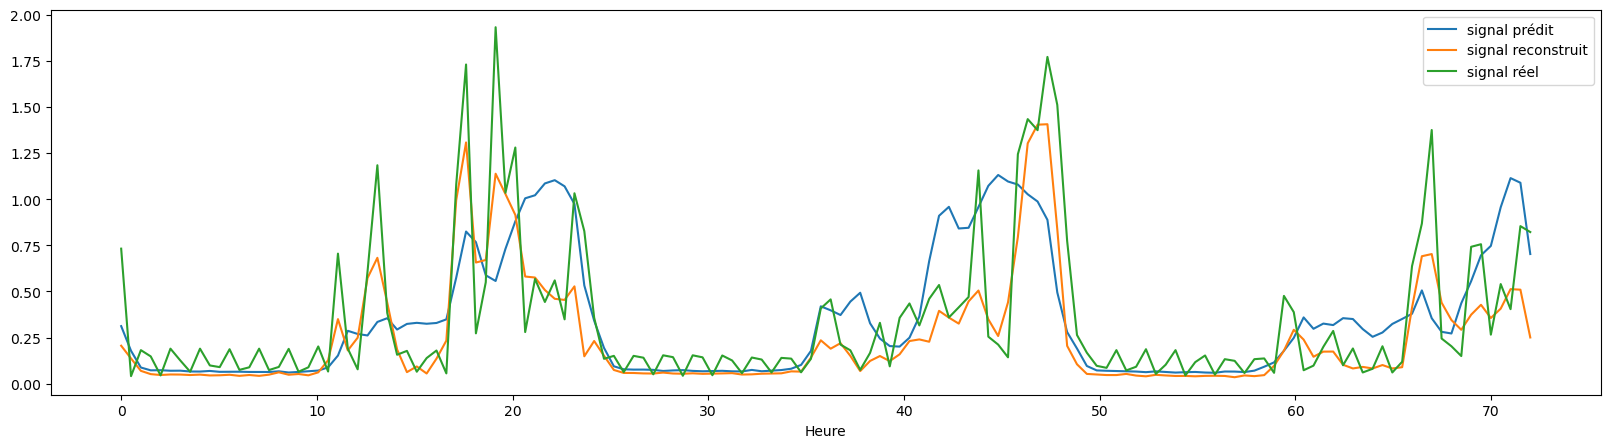

  1%|          | 2/307 [00:00<02:28,  2.05it/s]

7056 7056
0.14200177463117392


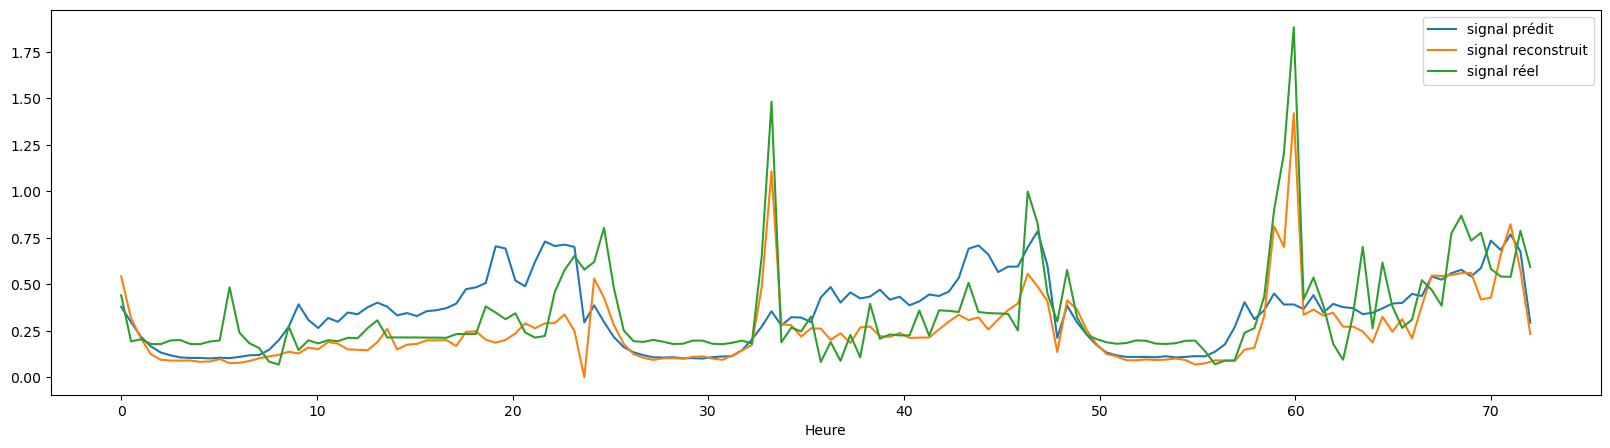

  1%|          | 3/307 [00:01<02:24,  2.10it/s]

7056 7056
0.16181292280423745


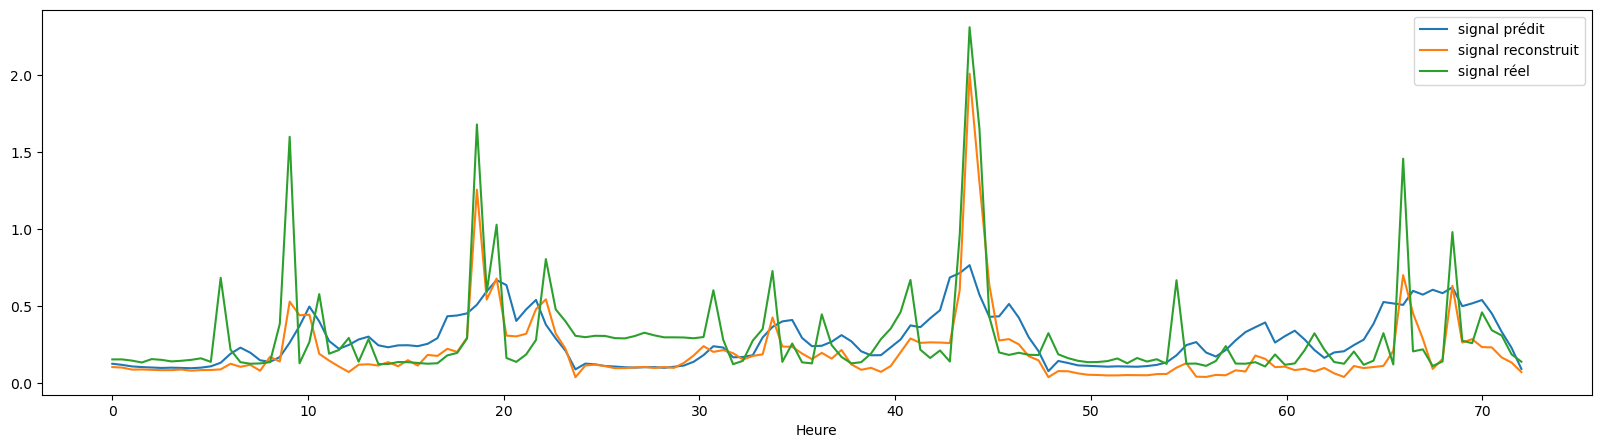

  1%|▏         | 4/307 [00:01<02:17,  2.21it/s]

7056 7056
0.2679871674346689


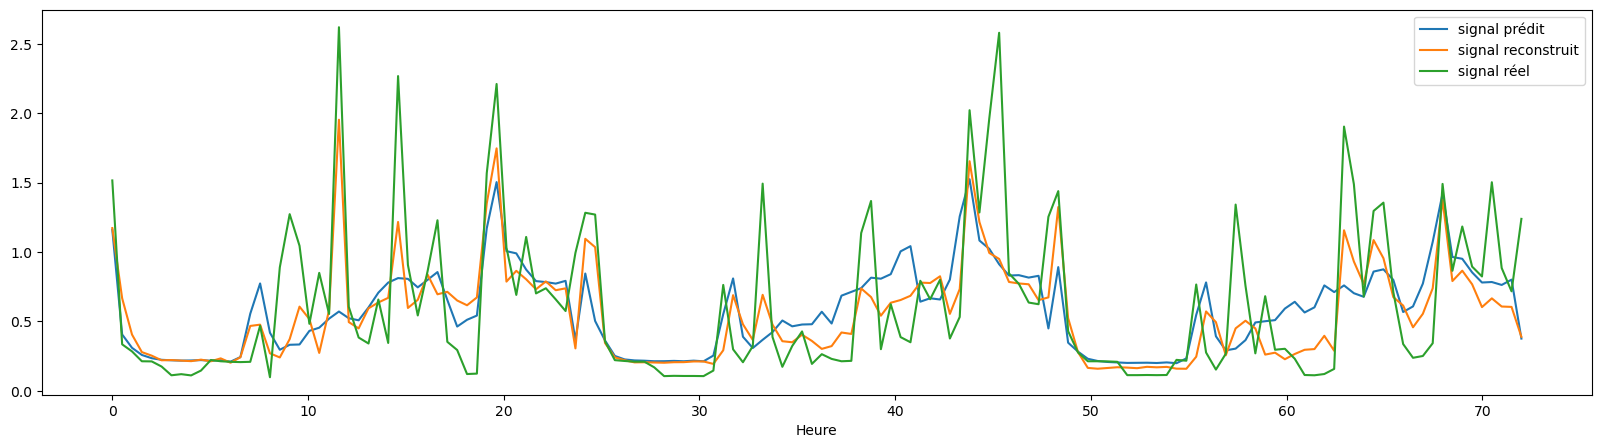

100%|██████████| 307/307 [01:11<00:00,  4.27it/s]

0.32550609845285094
0.5124265798049178
0.43269269342798694
0.3089773221127482
0.4412561971909527
0.3882369057721036


In [ ]:
lasso_models = {}
compute_MSE = []
compute_MSE1821 = []
compute_MSE813 = []
compute_MAE = []
compute_MAE1821 = []
compute_MAE813 = []

n_count = 0
for client in tqdm(client_challenges):
    n_count+=1
    spike = np.load('data_spike/'+str(client)+'.npy')
    atom = np.load('data_atoms/'+str(client)+'.npy')
    spike_test = np.load('data_spike_test/'+str(client)+'.npy')
    X_train, y_train = build_dataset(spike,min_date,364)    
    X_test, y_test = build_dataset(spike_test,min_date+365*day,n_days-1)
    model = Ridge(100)
    model.fit(X_train,y_train)
    lasso_models[client]=model
    y_pred = model.predict(X_test)
    pred_reconstructed = np.concatenate([reconstruct(atom,y_pred[i].reshape(15,1,48))[24:24+48] for i in range(len(y_pred))])
    true_reconstructed = np.concatenate([reconstruct(atom,y_test[i].reshape(15,1,48))[24:24+48] for i in range(len(y_test))])
    true_signal = np.array(load_signal(client,min_date+365*day+12*hour,max_date-(22)*day))
    compute_MSE.append(MSE(pred_reconstructed,true_signal))
    compute_MSE1821.append(MSE_1821(pred_reconstructed,true_signal))
    compute_MSE813.append(MSE_813(pred_reconstructed,true_signal))
    compute_MAE.append(MAE(pred_reconstructed,true_signal))
    compute_MAE1821.append(MAE_1821(pred_reconstructed,true_signal))
    compute_MAE813.append(MAE_813(pred_reconstructed,true_signal))

    if n_count<=5:
        print(len(true_signal),len(true_reconstructed))
        print(MSE(pred_reconstructed,true_signal))
        plt.figure(figsize=(20,5))
        plt.plot(np.linspace(0,24*3,3*48),pred_reconstructed[48*5:48*8],label='signal prédit')
        plt.plot(np.linspace(0,24*3,3*48),true_reconstructed[48*5:48*8],label='signal reconstruit')
        plt.plot(np.linspace(0,24*3,48*3),np.array(true_signal)[48*5:48*8],label='signal réel')
        plt.xlabel('Heure')
        plt.legend()
        plt.show()
print(np.mean(compute_MSE))
print(np.mean(compute_MSE1821))
print(np.mean(compute_MSE813))
print(np.mean(compute_MAE))
print(np.mean(compute_MAE1821))
print(np.mean(compute_MAE813))